# Spectral analysis with the HLI

## Prerequisites

- Understanding the gammapy data workflow, in particular what are DL3 events and instrument response functions (IRF).

## Context

This notebook is an introduction to gammapy analysis using the high level interface. 

Gammapy analysis consists in two main steps. 

The first one is data reduction: user selected observations  are reduced to a geometry defined by the user. 
It can be 1D (spectrum from a given extraction region) or 3D (with a sky projection and an energy axis). 
The resulting reduced data and instrument response functions (IRF) are called datasets in Gammapy.

The second step consists in setting a physical model on the datasets and fitting it to obtain relevant physical information.


**Objective: Create a 1D dataset of the Crab using the H.E.S.S. DL3 data release 1 and perform a simple model fitting of the Crab nebula.**

## Proposed approach

This notebook uses the high level `Analysis` class to orchestrate data reduction. In its current state, `Analysis` supports the standard analysis cases of joint or stacked 3D and 1D analyses. It is instantiated with an `AnalysisConfig` object that gives access to analysis parameters either directly or via a YAML config file. 

To see what is happening under-the-hood and to get an idea of the internal API, a second notebook performs the same analysis without using the `Analysis` class. 

In summary, we have to:

- Create an `~gammapy.analysis.AnalysisConfig` object and edit it to define the analysis configuration:
    - Define what observations to use
    - Define the geometry of the dataset (data and IRFs)
    - Define the model we want to fit on the dataset.
- Instantiate a `~gammapy.analysis.Analysis` from this configuration and run the different analysis steps
    - Observation selection
    - Data reduction
    - Model fitting
    - Estimating flux points


## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
from astropy import units as u
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.modeling.models import Models, SkyModel

## Analysis configuration

For configuration of the analysis we use the [YAML](https://en.wikipedia.org/wiki/YAML) data format. YAML is a machine readable serialisation format, that is also friendly for humans to read. In this tutorial we will write the configuration file just using Python strings, but of course the file can be created and modified with any text editor of your choice.

Here is what the configuration for our analysis looks like:

In [9]:
yaml_str = """
observations:
    datastore: $GAMMAPY_DATA/hess-dl3-dr1
    obs_cone: {frame: icrs, lon: 83.633 deg, lat: 22.014 deg, radius: 5 deg}
#    obs_ids: [23592, 23559]

datasets:
    type: 1d
    stack: true
    geom:
        axes:
            energy: {min: 0.5 TeV, max: 30 TeV, nbins: 20}
            energy_true: {min: 0.1 TeV, max: 50 TeV, nbins: 40}
    on_region: {frame: icrs, lon: 83.633 deg, lat: 22.014 deg, radius: 0.11 deg}
    containment_correction: true
    safe_mask:
       methods: ['offset-max']
       parameters: {offset_max: 2.0 deg}
    background:
        method: reflected
fit:
    fit_range: {min: 0.5 TeV, max: 30 TeV}

flux_points:
    energy: {min: 0.5 TeV, max: 30 TeV, nbins: 10}
"""

config = AnalysisConfig.from_yaml(yaml_str)
print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
        n_jobs: 1
        datasets_file: null
        models_file: null
    observations:
        datastore: $GAMMAPY_DATA/hess-dl3-dr1
        obs_ids: []
        obs_file: null
        obs_cone: {frame: icrs, lon: 83.633 deg, lat: 22.014 deg, radius: 5.0 deg}
        obs_time: {start: null, stop: null}
        required_irf: [aeff, edisp, psf, bkg]
    datasets:
        type: 1d
        stack: true
        geom:
            wcs:
                skydir: {frame: null, lon: null, lat: null}
                binsize: 0.02 deg
                width: {width: 5.0 deg, height: 5.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 2.5 deg}
            axes:
                energy: {min: 0.5 TeV, max: 30.0 TeV, nbins: 20}
                energy_true: {min: 0.1 TeV, max: 50.0 TeV, nbins: 40}
        map_selection: [counts, exposure, bac

Note that you can load it from a yaml file, e.g.

In [10]:
# config = AnalysisConfig.read("config-1d.yaml")
# # the AnalysisConfig gives access to the various parameters used from logging to reduced dataset geometries
# print(config)

### Setting the data to use

We want to use Crab runs from the H.E.S.S. DL3-DR1. We define here the datastore and a cone search of observations pointing with 5 degrees of the Crab nebula. Parameters can be set directly or as a python dict.

PS: do not forget to setup your environment variable _$GAMMAPY\_DATA_ to your local directory containing the H.E.S.S. DL3-DR1 as described in [getting started](../../getting-started/index.rst#quickstart-setup).

In [11]:
# We define the datastore containing the data
config.observations.datastore = "$GAMMAPY_DATA/hess-dl3-dr1"

# We define the cone search parameters
config.observations.obs_cone.frame = "icrs"
config.observations.obs_cone.lon = "83.633 deg"
config.observations.obs_cone.lat = "22.014 deg"
config.observations.obs_cone.radius = "5 deg"

# Equivalently we could have set parameters with a python dict
# config.observations.obs_cone = {"frame": "icrs", "lon": "83.633 deg", "lat": "22.014 deg", "radius": "5 deg"}

### Setting of the On region

In [12]:
config.datasets.on_region = {
    "frame": "icrs",
    "lon": "83.633 deg",
    "lat": "22.014 deg",
    "radius": "0.11 deg",
}

### Setting the background maker

In [13]:
config.datasets.background.method = "reflected"

### Setting the exclusion mask

In order to properly adjust the background normalisation on regions without gamma-ray signal, one needs to define an exclusion mask for the background normalisation.
For this tutorial, we use the following one ``$GAMMAPY_DATA/joint-crab/exclusion/exclusion_mask_crab.fits.gz``

In [14]:
config.datasets.background.exclusion = (
    "$GAMMAPY_DATA/joint-crab/exclusion/exclusion_mask_crab.fits.gz"
)

We're all set. 
But before we go on let's see how to save or import `AnalysisConfig` objects though YAML files.

### Using YAML configuration files for setting/writing the Data Reduction parameters

One can export/import the `AnalysisConfig` to/from a YAML file.

In [15]:
config.write("config.yaml", overwrite=True)

In [16]:
config = AnalysisConfig.read("config.yaml")
print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
        n_jobs: 1
        datasets_file: null
        models_file: null
    observations:
        datastore: $GAMMAPY_DATA/hess-dl3-dr1
        obs_ids: []
        obs_file: null
        obs_cone: {frame: icrs, lon: 83.633 deg, lat: 22.014 deg, radius: 5.0 deg}
        obs_time: {start: null, stop: null}
        required_irf: [aeff, edisp, psf, bkg]
    datasets:
        type: 1d
        stack: true
        geom:
            wcs:
                skydir: {frame: null, lon: null, lat: null}
                binsize: 0.02 deg
                width: {width: 5.0 deg, height: 5.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 2.5 deg}
            axes:
                energy: {min: 0.5 TeV, max: 30.0 TeV, nbins: 20}
                energy_true: {min: 0.1 TeV, max: 50.0 TeV, nbins: 40}
        map_selection: [counts, exposure, bac

## Running the first step of the analysis: the Data Reduction

### Configuration of the analysis
We first create an `~gammapy.analysis.Analysis` object from our configuration.

In [17]:
analysis = Analysis(config)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}


###  Observation selection

We can directly select and load the observations from disk using `~gammapy.analysis.Analysis.get_observations()`:

In [18]:
analysis.get_observations()

Fetching observations.
Observations selected: 4 out of 4.
Number of selected observations: 4


The observations are now available on the `Analysis` object. The selection corresponds to the following ids:

In [19]:
analysis.observations.ids

['23523', '23526', '23559', '23592']

To see how to explore observations, please refer to the following notebook: [CTA with Gammapy](../data/cta.ipynb) or  [HESS with Gammapy](../data/hess.ipynb) 

### Running the Data Reduction

Now we proceed to the data reduction. In the config file we have chosen a WCS map geometry, energy axis and decided to stack the maps. We can run the reduction using `.get_datasets()`:

In [20]:
%%time
analysis.get_datasets()

Reducing spectrum datasets.
Creating the background Maker.


CPU times: user 3.37 s, sys: 237 ms, total: 3.61 s
Wall time: 3.61 s


### Results exploration
As we have chosen to stack the data, one can print what contains the unique entry of the datasets:

In [21]:
print(analysis.datasets[0])

SpectrumDatasetOnOff
--------------------

  Name                            : stacked 

  Total counts                    : 665 
  Total background counts         : 58.68
  Total excess counts             : 606.32

  Predicted counts                : 84.08
  Predicted background counts     : 84.08
  Predicted excess counts         : nan

  Exposure min                    : 2.90e+07 m2 s
  Exposure max                    : 2.64e+09 m2 s

  Number of total bins            : 20 
  Number of fit bins              : 20 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 1891.50

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1364 
  Acceptance                      : 20 
  Acceptance off                  : 499 



As you can see the dataset uses WStat with the background computed with the Reflected Background method during the data reduction, but no source model has been set yet.

The counts, exposure and background, etc are directly available on the dataset and can be printed:

In [22]:
info_table = analysis.datasets.info_table()
info_table

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,665,606.31591796875,42.286540453477166,58.68408966064453,84.08349153948839,84.08349153948839,nan,29014048.0,2636602112.0,6313.811659421773,6742.0,0.10532464949404297,0.009294558156968986,0.09603009254543986,20,20,wstat,1891.4967380845833,1364,20.0,464.8619384765625,0.043023526668548584


In [23]:
print(
    f"Tobs={info_table['livetime'].to('h')[0]:.1f} Excess={info_table['excess'].value[0]:.1f} \
Significance={info_table['sqrt_ts'][0]:.2f}"
)

Tobs=1.8 h Excess=606.3 Significance=42.29


### Save dataset to disk

It is common to run the preparation step independent of the likelihood fit, because often the preparation of counts, collection are and energy dispersion is slow if you have a lot of data. We first create a folder:

In [24]:
path = Path("hli_spectrum_analysis")
path.mkdir(exist_ok=True)

And then write the stacked dataset to disk by calling the dedicated `write()` method:

In [25]:
filename = path / "crab-stacked-dataset.fits.gz"
analysis.datasets.write(filename, overwrite=True)

## Model fitting

### Creation of the model
First, let's create a model to be adjusted. As we are performing a 1D Analysis, only a spectral model is needed within the `SkyModel` object.
Here is a pre-defined YAML configuration file created for this 1D analysis:

In [31]:
model_str = """
components:
- name: source
  type: SkyModel
  spectral:
    type: PowerLawSpectralModel
    parameters:
      - name: index
        frozen: false
        scale: 1.0
        unit: ''
        value: 2.6
      - name: amplitude
        frozen: false
        scale: 1.0
        unit: cm-2 s-1 TeV-1
        value: 5.0e-11
      - name: reference
        frozen: true
        scale: 1.0
        unit: TeV
        value: 1.0
"""
model_1d = Models.from_yaml(model_str)
print(model_1d)

Models

Component 0: SkyModel

  Name                      : source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      2.600   +/-    0.00             
    amplitude                     :   5.00e-11   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         




Or from a yaml file, e.g. 

In [32]:
# model_1d = Models.read("model-1d.yaml")
# print(model_1d)

This object is a `Models` and it contains a `SkyModel`. In order to customise it for our analysis, the creation of a copy is needed:

In [33]:
my_model = model_1d[0].copy(name="crab")
print(my_model)

SkyModel

  Name                      : crab
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      2.600   +/-    0.00             
    amplitude                     :   5.00e-11   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         




Now we set the model on the analysis object:

In [34]:
analysis.set_models([my_model])

Reading model.
Models

Component 0: SkyModel

  Name                      : crab
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      2.600   +/-    0.00             
    amplitude                     :   5.00e-11   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         




### Setting fitting parameters
`Analysis` can perform a few modeling and fitting tasks besides data reduction. Parameters have then to be passed to the configuration object.

Here we define the energy range on which to perform the fit. We also set the energy edges used for flux point computation. 

In [35]:
config.fit.fit_range.min = 1 * u.TeV
config.fit.fit_range.max = 20 * u.TeV
config.flux_points.energy = {"min": "1 TeV", "max": "20 TeV", "nbins": 6}

### Running the fit

In [36]:
%%time
analysis.run_fit()

Fitting datasets.
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 37
	total stat : 10.29

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



CPU times: user 359 ms, sys: 3.26 ms, total: 362 ms
Wall time: 355 ms


### Exploration of the fit results

In [37]:
print(analysis.fit_result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 37
	total stat : 10.29

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [38]:
model_1d.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str6,str8,str9,float64,str14,int64,float64,float64,bool,bool,str1
source,spectral,index,2.6000e+00,,0.000e+00,nan,nan,False,False,
source,spectral,amplitude,5.0000e-11,cm-2 s-1 TeV-1,0.000e+00,nan,nan,False,True,
source,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,


To check the fit is correct, we compute the excess spectrum with the predicted counts.

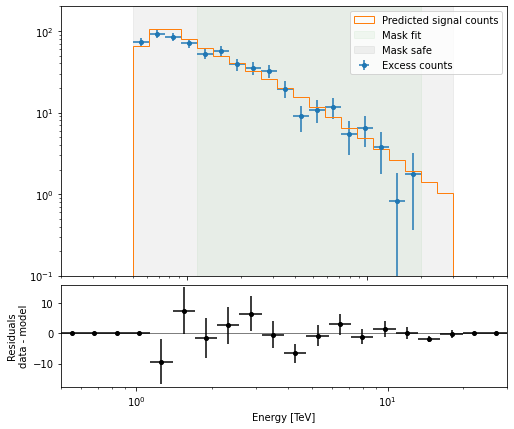

In [39]:
ax_spectrum, ax_residuals = analysis.datasets[0].plot_fit()
ax_spectrum.set_ylim(0.1, 200)
ax_spectrum.set_xlim(0.2, 60)
analysis.datasets[0].plot_masks(ax=ax_spectrum);

### Serialisation of the fit result
This is how we can write the model back to file again:

In [40]:
filename = path / "model-best-fit.yaml"
analysis.models.write(filename, overwrite=True)

In [41]:
!cat hli_spectrum_analysis/model-best-fit.yaml

 tcsh initialization done
components:
-   name: crab
    type: SkyModel
    spectral:
        type: PowerLawSpectralModel
        parameters:
        -   name: index
            value: 2.6768369901897127
            error: 0.103500228270503
        -   name: amplitude
            value: 4.679478012928264e-11
            unit: cm-2 s-1 TeV-1
            error: 4.678684405582121e-12
        -   name: reference
            value: 1.0
            unit: TeV
            frozen: true
covariance: model-best-fit_covariance.dat


## Creation of the Flux points

### Configuration of the `FluxPointEstimator`

In [42]:
analysis.config.flux_points.source = "crab"
analysis.config.flux_points.energy: {
    "min": "1.0 TeV",
    "max": "20.0 TeV",
    "nbins": 8,
}
# analysis.config.flux_points.parameters: {selection_optional: all}

### Running the estimation

In [43]:
analysis.get_flux_points()

Calculating flux points.
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend

      e_ref                 dnde                 dnde_ul                dnde_err             sqrt_ts      
       TeV            1 / (cm2 s TeV)        1 / (cm2 s TeV)        1 / (cm2 s TeV)                       
------------------ ---------------------- ---------------------- ---------------------- ------------------
1.2561862508429897  2.496887280755603e-11  3.019240757626381e-11 2.4538348295830748e-12 1

### Accessing the results
You plot access to the results with the stored object `analysis.flux_points.data` that is simply a dictionnay with  the flux points. Many functions are available. Here let's just print the flux points:

In [44]:
crab_fp = analysis.flux_points.data
crab_fp.to_table(sed_type="dnde", formatted=True)

e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred [1],npred_excess [1],stat,is_ul,counts [1],success,norm_scan [11],stat_scan [11]
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,bool,float64,bool,float64,float64
1.256,0.924,1.708,2.497e-11,2.454e-12,2.531e-12,2.379e-12,3.019e-11,391.705,19.792,115.89932923616581,109.6974,2.453,False,116.0,True,0.200 .. 5.000,149.716 .. 532.174
2.096,1.708,2.572,6.567e-12,7.878e-13,8.178e-13,7.589e-13,8.265e-12,250.967,15.842,79.00995582677143,74.179214,0.244,False,79.0,True,0.200 .. 5.000,100.726 .. 337.347
3.496,2.572,4.753,1.629e-12,2.163e-13,2.254e-13,2.075e-13,2.099e-12,199.767,14.134,64.99808211039613,60.821083,4.447,False,65.0,True,0.200 .. 5.000,84.138 .. 291.898
5.833,4.753,7.158,4.655e-13,1.001e-13,1.070e-13,9.338e-14,6.937e-13,88.590,9.412,24.133120135944353,22.806488,0.725,False,24.0,True,0.200 .. 5.000,35.669 .. 89.296
9.730,7.158,13.228,1.102e-13,2.918e-14,3.161e-14,2.692e-14,1.786e-13,48.538,6.967,16.936094673570636,15.573182,0.575,False,17.0,True,0.200 .. 5.000,20.927 .. 68.065
16.233,13.228,19.921,1.523e-14,1.034e-14,1.239e-14,8.463e-15,4.443e-14,6.003,2.450,2.954099038431944,2.5607193,0.608,False,3.0,True,0.200 .. 5.000,2.084 .. 28.509


Let's plot the flux points with their likelihood profile

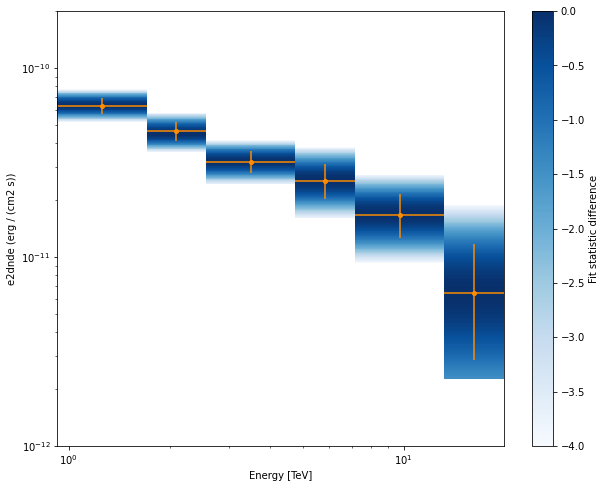

In [45]:
plt.figure(figsize=(10, 8))
ax_sed = crab_fp.plot(sed_type="e2dnde", color="darkorange")
ax_sed.set_ylim(1.0e-12, 2.0e-10)
ax_sed.set_xlim(0.5, 40)
crab_fp.plot_ts_profiles(ax=ax_sed, sed_type="e2dnde");

### Serialisation of the results
The flux points can be exported to a fits table following the format defined [here](https://gamma-astro-data-formats.readthedocs.io/en/latest/spectra/flux_points/index.html) 

In [46]:
filename = path / "flux-points.fits"
analysis.flux_points.write(filename, overwrite=True)

## Plotting the final results of the 1D Analysis

We can plot of the spectral fit with its error band overlaid with the flux points:

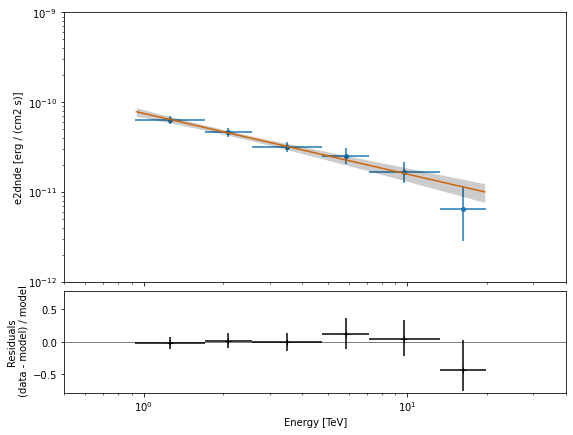

In [47]:
ax_sed, ax_residuals = analysis.flux_points.plot_fit()
ax_sed.set_ylim(1.0e-12, 1.0e-9)
ax_sed.set_xlim(0.5, 40)
plt.savefig("1D-Analysis-spectrum.png")

## What's next?

You can look at the same analysis without the high level interface in [spectral analysis](../analysis/1D/spectral_analysis.ipynb).

As we can store the best model fit, you can overlaid the fit results of both methods on an unique plot.